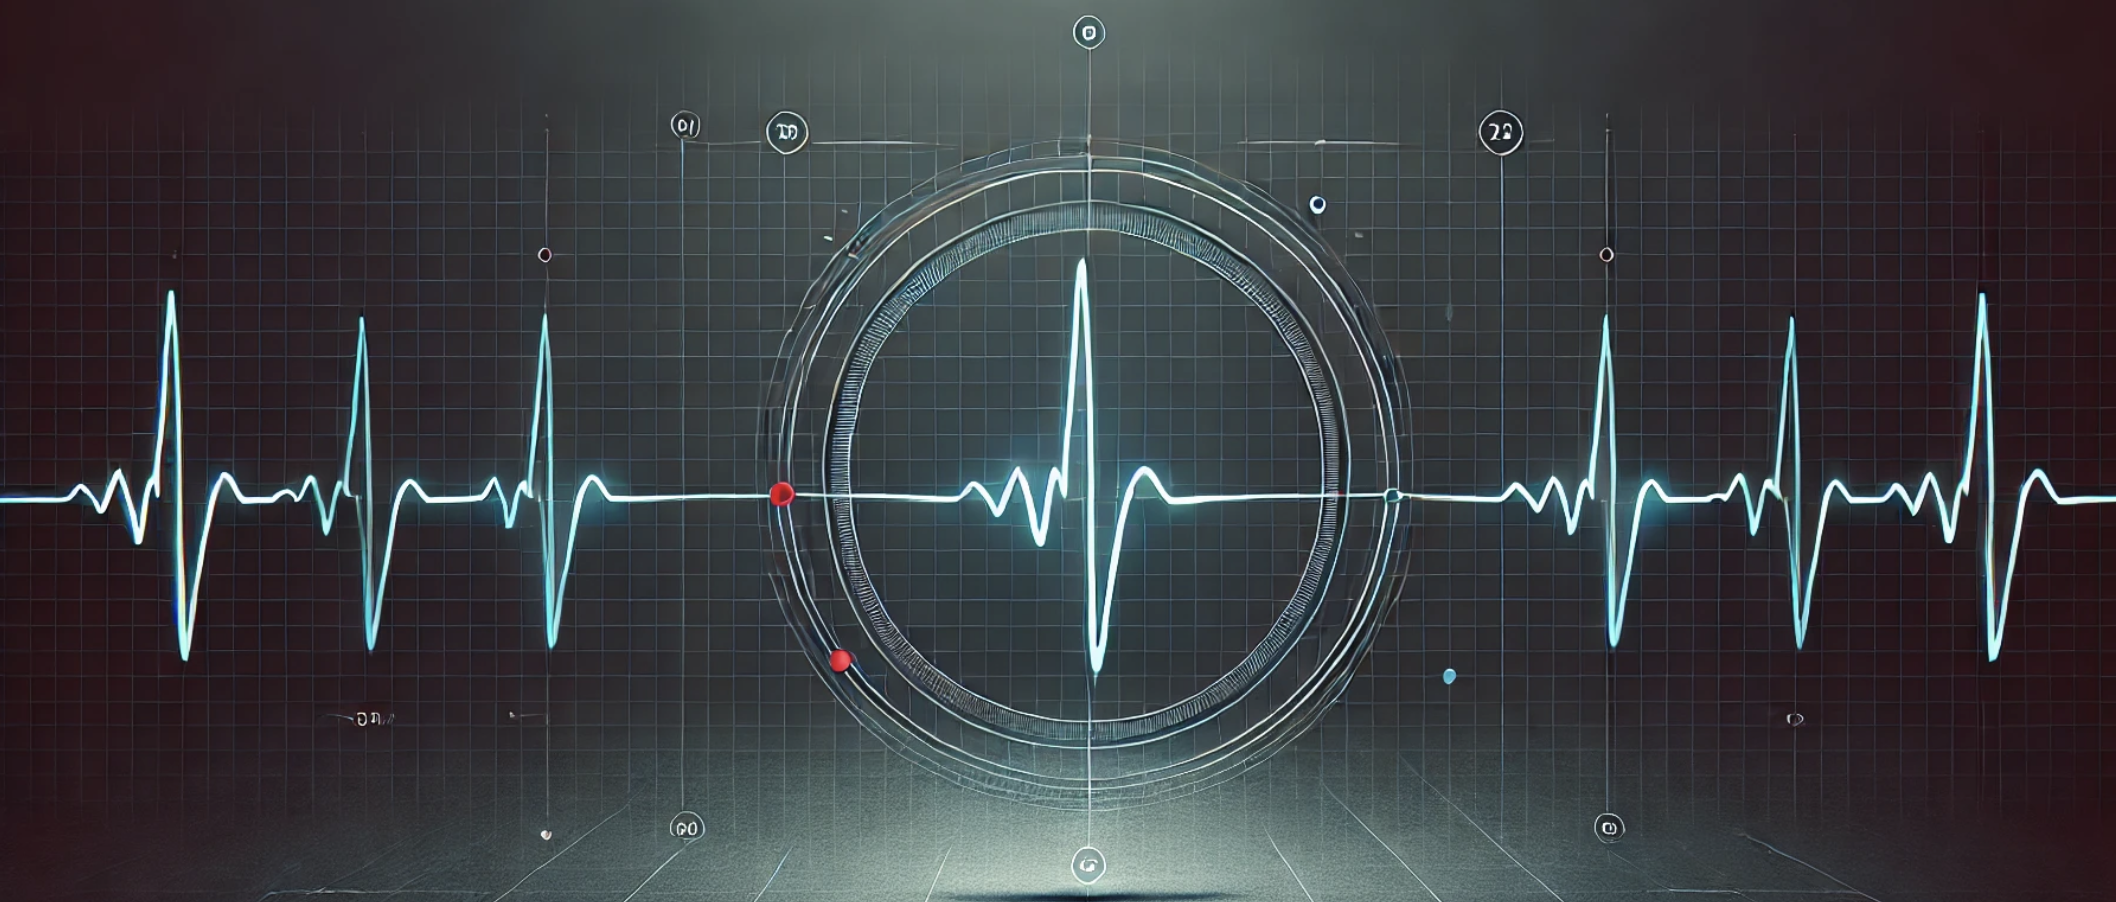

# Szívritmus minták elemzése rekurrens autoenkóderrel

Az alábbi feladatban 10 különböző szívritmus mintát fogsz vizsgálni annak érdekében, hogy megállapítsd, melyek közülük nem egészségesek. A szívritmus adatok kiértékelése egy előre betanított rekurrens autoenkóderrel történik. Az autoenkóder a bemeneti adatokat kódolja, majd dekódolja, és a kódolt és dekódolt minták közötti rekonstrukciós veszteség alapján dönti el, hogy az adott minta normális vagy rendellenes. Az előre betanított modellben a rekonstrukciós veszteség **25** alatti értékei egészséges szívritmusra utalnak, míg a **25 fölötti értékek** rendellenességet jeleznek.

## Feladat menete:

1. **Töltsd be a szükséges adatokat.**
2. **Fejezd me az autoenkóder `forward()` függvényét és töltsd be a modellt.**
3. **Végezz predikciót a 10 szívritmus mintán.**
4. **A modell által kódolt és dekódolt, valamint az eredeti minták közötti veszteség alapján döntsd el, melyik minta térhet el az egészségestől.** A modellben az előre meghatározott küszöbérték 25, ami alapján eldönthető, hogy egy minta egészséges-e vagy sem.
5. **Az eredményeket bináris listában add meg, ahol:**
   - **0:** az adott minta egészséges
   - **1:** az adott minta nem egészséges

   Példa: `[1, 0, 1, 0, 1, 0, 1, 0, 1, 0]` - figyelj a minták sorrendjére!


In [1]:
%%capture

!gdown 125mhiJ71m-32-1huXmYdCDwGBRMm9ZD4
!gdown 1EcX1ONKDuL6Hz52suKu596RDSQY3wagV

In [41]:
import seaborn as sns
import numpy as np
import torch
import pandas as pd
from torch import nn, optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [42]:
sample_df = pd.read_pickle('ecg_sample_df.pkl')

In [43]:
sample_df

,att1,att2,att3,att4,att5,att6,att7,att8,att9,att10,...,att131,att132,att133,att134,att135,att136,att137,att138,att139,att140
0,1.109529,-0.554619,-2.450204,-3.598719,-4.643241,-4.553939,-3.039402,-2.072252,-1.857622,-0.752169,...,0.139927,0.217109,1.015969,1.512369,1.561586,1.712768,1.433678,1.196686,0.259135,0.221382
1,-0.217190,-1.708694,-2.800415,-3.622277,-3.432675,-2.874791,-2.101375,-1.639645,-1.561366,-1.062705,...,1.731924,1.841530,2.169950,2.260348,1.973294,1.532806,1.314108,1.346867,0.958946,-0.307490
2,-0.186500,-2.682488,-4.016882,-4.218122,-3.841665,-2.994059,-1.973940,-1.639707,-1.291207,-0.566769,...,0.808746,0.781289,0.725187,1.068264,1.129702,0.940981,1.008044,1.564257,2.151476,0.180054
3,-0.362239,-1.784480,-2.508320,-3.354448,-4.064445,-4.082638,-3.147264,-1.948188,-1.615900,-1.153468,...,1.658329,1.568298,1.050271,0.106586,-0.885079,-1.624499,-1.720991,-1.110514,-0.210702,-1.141483
4,0.499466,-0.932613,-1.892121,-2.639432,-2.793014,-2.365073,-1.177244,-0.062558,0.214153,0.761216,...,-0.119882,-0.613996,-0.997442,-1.409782,-1.727467,-2.127232,-1.994103,-1.936972,-2.201610,-3.950769
5,-0.651725,-3.386570,-4.044287,-4.446820,-3.682020,-2.375433,-1.715458,-1.476891,-0.562274,-0.133711,...,0.812132,1.575732,1.611060,1.602952,1.163150,0.563584,0.172937,0.526997,1.217370,-1.663490
6,-0.478994,-1.327982,-1.963005,-2.541905,-2.842115,-2.977941,-2.961970,-2.839691,-2.737302,-2.503085,...,-0.250032,-0.779461,-1.313335,-1.942890,-2.490243,-2.708918,-2.383379,-1.640300,-0.851672,0.052443
7,-0.165463,-1.032245,-1.604450,-1.914622,-1.799545,-1.549082,-1.159642,-0.825674,-0.737608,-0.635467,...,0.110704,-0.023472,-0.298297,-0.971539,-2.162760,-3.073399,-3.669672,-4.441123,-4.758792,-5.150433
8,-0.301966,-1.103448,-1.257828,-1.495176,-1.439479,-1.111492,-0.687793,-0.438963,-0.465610,-0.162947,...,0.488933,0.161018,-0.340279,-1.147963,-1.936385,-2.850740,-3.581939,-4.649048,-5.203030,-5.797645
9,0.348943,-0.611009,-1.136266,-2.162909,-2.835477,-3.417802,-3.182607,-2.724920,-2.144938,-1.567635,...,-1.365031,-1.959224,-2.560654,-3.131337,-3.443787,-2.772122,-2.047622,-0.664174,-0.214032,0.743974


In [44]:
def create_dataset(df):

  sequences = df.astype(np.float32).to_numpy().tolist()
  dataset = [torch.tensor(s).unsqueeze(1).float() for s in sequences]
  n_seq, seq_len, n_features = torch.stack(dataset).shape

  return dataset, seq_len, n_features

test_dataset, seq_len, n_features = create_dataset(sample_df)



class Encoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(Encoder, self).__init__()

    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim

    self.rnn1 = nn.LSTM(
      input_size=n_features,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )

    self.rnn2 = nn.LSTM(
      input_size=self.hidden_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True
    )

  def forward(self, x):
    x = x.reshape((1, self.seq_len, self.n_features))

    x, (_, _) = self.rnn1(x)
    x, (hidden_n, _) = self.rnn2(x)

    return hidden_n.reshape((self.n_features, self.embedding_dim))

class Decoder(nn.Module):

  def __init__(self, seq_len, input_dim=64, n_features=1):
    super(Decoder, self).__init__()

    self.seq_len, self.input_dim = seq_len, input_dim
    self.hidden_dim, self.n_features = 2 * input_dim, n_features

    self.rnn1 = nn.LSTM(
      input_size=input_dim,
      hidden_size=input_dim,
      num_layers=1,
      batch_first=True
    )


    self.rnn2 = nn.LSTM(
      input_size=input_dim,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )

    self.output_layer = nn.Linear(self.hidden_dim, n_features)

  def forward(self, x):
    x = x.repeat(self.seq_len, self.n_features)
    x = x.reshape((self.n_features, self.seq_len, self.input_dim))

    x, (hidden_n, cell_n) = self.rnn1(x)
    x, (hidden_n, cell_n) = self.rnn2(x)
    x = x.reshape((self.seq_len, self.hidden_dim))

    return self.output_layer(x)

class RecurrentAutoencoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(RecurrentAutoencoder, self).__init__()

    self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
    self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)

  def forward(self, x):
    # TODO:

    x = self.encoder(x)
    x = self.decoder(x)

    return x

In [45]:
print(seq_len, n_features)
print(len(test_dataset[0]))

140 1
140


In [46]:
# TODO:
model = RecurrentAutoencoder(seq_len, n_features).to(device)

In [47]:
model = torch.load('/content/ecg_autoencoder_model.pth', map_location=torch.device('cpu'))

<ipython-input-47-8889c28f0566>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('/content/ecg_autoencoder_model.pth', map_location=torch.device('cpu'))
/

In [48]:
def predict(model, data, threshold = 25):
  predictions, losses = [], []
  criterion = nn.L1Loss(reduction='sum').to(device)
  with torch.no_grad():
    model = model.eval()

    for seq_true in data:

      # TODO: Prediktálj a szívritmus mintákra:
      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)

      predictions.append(seq_pred.cpu().numpy().flatten())
      losses.append(loss.item())


  return predictions, losses

In [49]:
predictions, pred_losses = predict(model, test_dataset)

In [50]:
print(pred_losses)

[10.223000526428223, 6.085221767425537, 5.886541843414307, 7.839832782745361, 11.031255722045898, 7.2976484298706055, 45.67340087890625, 49.93076705932617, 52.478126525878906, 56.395660400390625]


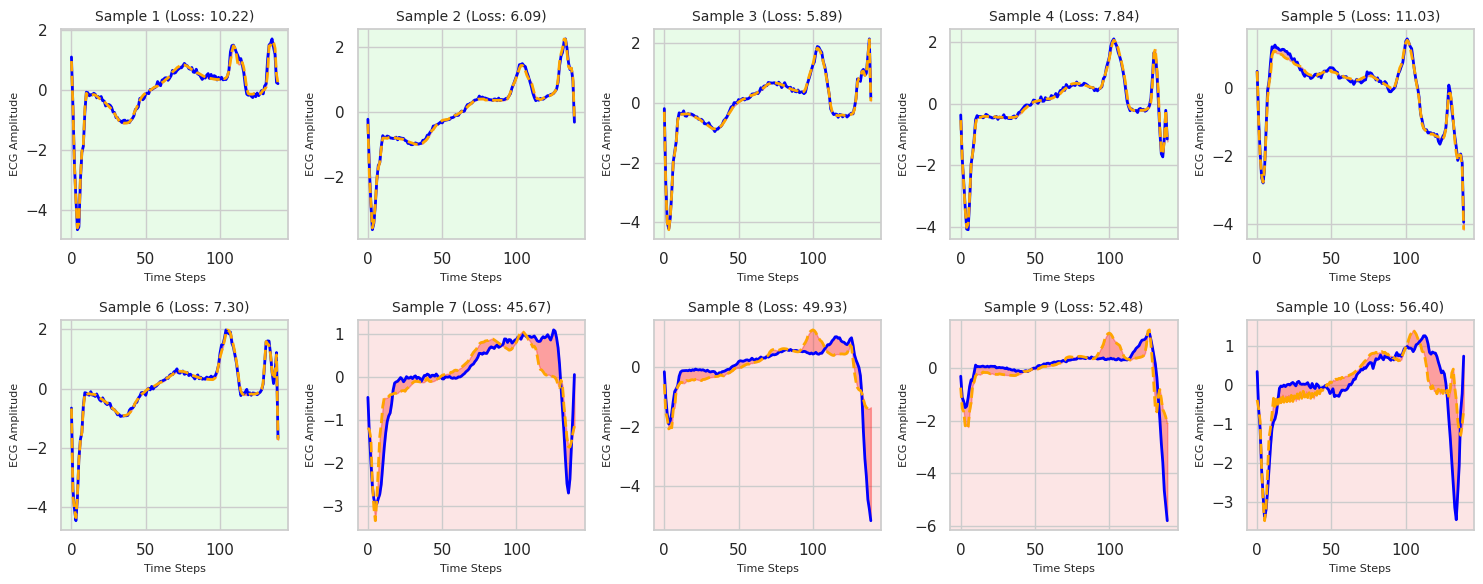

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

criterion = torch.nn.L1Loss(reduction='sum').to('cpu')

def plot_predictions(original, predictions, num_samples=10, grid_size=(2, 5), threshold=25):
    original = np.array(original)
    predictions = np.array(predictions)

    fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(15, 6))
    axes = axes.flatten()

    for i in range(min(num_samples, grid_size[0] * grid_size[1])):
        original_1d = original[i].flatten()
        predictions_1d = predictions[i].flatten()

        original_tensor = torch.tensor(original_1d).to('cpu')
        predictions_tensor = torch.tensor(predictions_1d).to('cpu')

        loss = criterion(predictions_tensor, original_tensor).item()

        time_steps = np.arange(len(original_1d))

        ax = axes[i]
        ax.plot(time_steps, original_1d, label='Original', color='blue', linewidth=2)
        ax.plot(time_steps, predictions_1d, label='Predicted', color='orange', linestyle='--', linewidth=2)

        ax.fill_between(time_steps, original_1d, predictions_1d,
                        where=original_1d != predictions_1d, color='red', alpha=0.3)

        ax.set_title(f'Sample {i+1} (Loss: {loss:.2f})', fontsize=10)
        ax.set_xlabel('Time Steps', fontsize=8)
        ax.set_ylabel('ECG Amplitude', fontsize=8)

        if loss > threshold:
            ax.set_facecolor('lightcoral')
        else:
            ax.set_facecolor('lightgreen')

        ax.patch.set_alpha(0.2)

    fig.tight_layout()
    plt.show()

plot_predictions(test_dataset, predictions, num_samples=10, grid_size=(2, 5), threshold=25)
